In [2]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
df = pd.read_csv('C:\\Users\\AAA\\Desktop\\dev\\LSTM과 BERT\\gangnamgu.csv')
data= df.iloc[:,1:2]
data

,trade_price_idx_value
0,74.2
1,75.8
2,78.1
3,81.4
4,83.6
...,...
160,109.7
161,109.3
162,108.3
163,107.5


,trade_price_idx_value
4,78.62
5,80.54
6,82.10
7,83.18
8,83.66
...,...
160,109.90
161,110.36
162,110.20
163,109.38


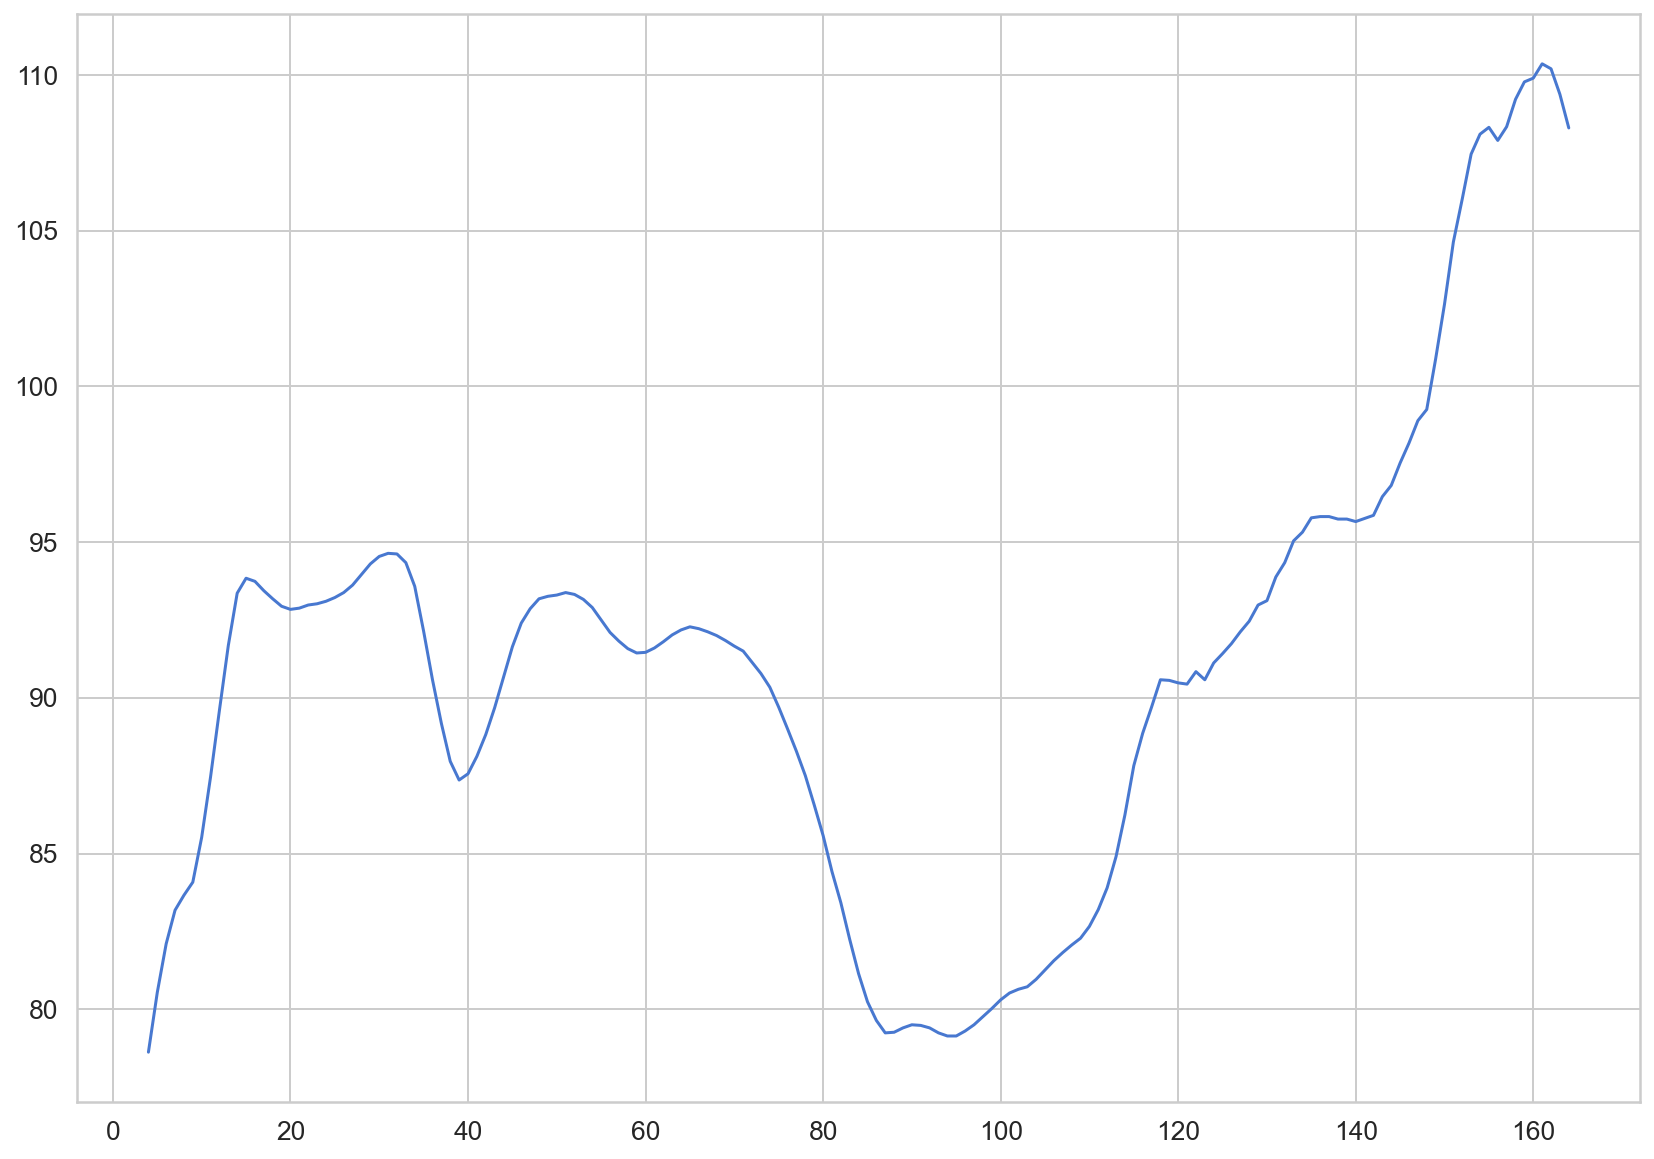

In [4]:
roll = data['trade_price_idx_value'].rolling(window=5)
rolled= roll.mean()
rolled.plot()
rolled=pd.DataFrame(rolled)
rolled=rolled.dropna()
rolled

In [5]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [6]:
#지도학습용 데이터로 변환
seq_length = 5
X, y = create_sequences(rolled, seq_length)

for i in range(3):
    print(X[i], y[i])

[[78.62]
 [80.54]
 [82.1 ]
 [83.18]
 [83.66]] [84.08]
[[80.54]
 [82.1 ]
 [83.18]
 [83.66]
 [84.08]] [85.52]
[[82.1 ]
 [83.18]
 [83.66]
 [84.08]
 [85.52]] [87.46]


In [7]:
#학습용, 검증용, 시험용으로 분리
train_size = int(135 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:135], y[train_size:135]
X_test, y_test = X[0:], y[0:]

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

X_train =  sc.fit_transform(X_train.reshape(-1,1)).reshape(-1,seq_length)
y_train =sc.fit_transform(y_train.reshape(-1,1))
X_val = sc.fit_transform(X_val.reshape(-1,1)).reshape(-1,seq_length)
y_val =sc.fit_transform(y_val.reshape(-1,1))
X_test =sc.fit_transform(X_test.reshape(-1,1)).reshape(-1,seq_length)
y_test = sc.fit_transform(y_test.reshape(-1,1))

In [8]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)

True
학습을 진행하는 기기: cuda:0


In [9]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
X_val = torch.tensor(X_val).float().to(device)
y_val = torch.tensor(y_val).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test ).float().to(device)

In [10]:
class Predictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(Predictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [11]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0
        for idx, seq in enumerate(train_data): 
            model.module.reset_hidden_state() # seq 별 hidden state reset
            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))
        
        if val_data is not None:
            with torch.no_grad():
                val_loss = 0
                for val_idx, val_seq in enumerate(val_data):

                    model.module.reset_hidden_state() # seq 별로 hidden state 초기화 
                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):          
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :
                    print('\n Early Stopping')
                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [12]:
model= torch.load('C:\\Users\\AAA\\Desktop\\dev\\LSTM과 BERT\\model6.pt')
model.train()

DataParallel(
  (module): Predictor(
    (lstm): LSTM(1, 3)
    (linear): Linear(in_features=3, out_features=1, bias=True)
  )
)

In [54]:
#########################################

model = Predictor(
    n_features=1,
    n_hidden=2,
    seq_len=seq_length,
    n_layers=1
)
model= nn.DataParallel(model)
model.to(device)
#########################################

DataParallel(
  (module): Predictor(
    (lstm): LSTM(1, 2)
    (linear): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [13]:

model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.03388861665088269 val loss: 0.2020469605922699
Epoch 10 train loss: 0.047304882348894524 val loss: 0.18419243395328522
Epoch 20 train loss: 0.0498981726338604 val loss: 0.1833532154560089
Epoch 30 train loss: 0.04988226454049625 val loss: 0.18109016120433807
Epoch 40 train loss: 0.04965668496744776 val loss: 0.18101389706134796
Epoch 50 train loss: 0.04944135849709036 val loss: 0.17982889711856842
Epoch 60 train loss: 0.049612177803215605 val loss: 0.17961901426315308
Epoch 70 train loss: 0.04921242022990353 val loss: 0.17732688784599304
Epoch 80 train loss: 0.04646814620570728 val loss: 0.1780925691127777
Epoch 90 train loss: 0.046352700442420666 val loss: 0.17756301164627075


In [57]:
model.eval()

DataParallel(
  (module): Predictor(
    (lstm): LSTM(1, 2)
    (linear): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [14]:
#one step 예측
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.module.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

In [15]:
preds= sc.inverse_transform(np.array(preds).reshape(-1,1))
preds

array([[ 83.28027845],
       [ 83.65524114],
       [ 84.96004709],
       [ 86.75489299],
       [ 88.76501492],
       [ 90.72908809],
       [ 92.31024154],
       [ 92.7598004 ],
       [ 92.66624395],
       [ 92.38525082],
       [ 92.1413576 ],
       [ 91.91594083],
       [ 91.82194522],
       [ 91.85954942],
       [ 91.95352828],
       [ 91.99111014],
       [ 92.06624597],
       [ 92.17889853],
       [ 92.32899898],
       [ 92.55390402],
       [ 92.87198403],
       [ 93.18938296],
       [ 93.41297796],
       [ 93.50602825],
       [ 93.48742527],
       [ 93.22667454],
       [ 92.51644124],
       [ 91.16293387],
       [ 89.69031118],
       [ 88.36901152],
       [ 87.22247704],
       [ 86.66157752],
       [ 86.8482773 ],
       [ 87.37242955],
       [ 88.0300192 ],
       [ 88.84049314],
       [ 89.76588245],
       [ 90.69133688],
       [ 91.40790453],
       [ 91.84074732],
       [ 92.1413576 ],
       [ 92.21643574],
       [ 92.2539655 ],
       [ 92

In [16]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

MAE(y[0:],preds)

1.257629831664462

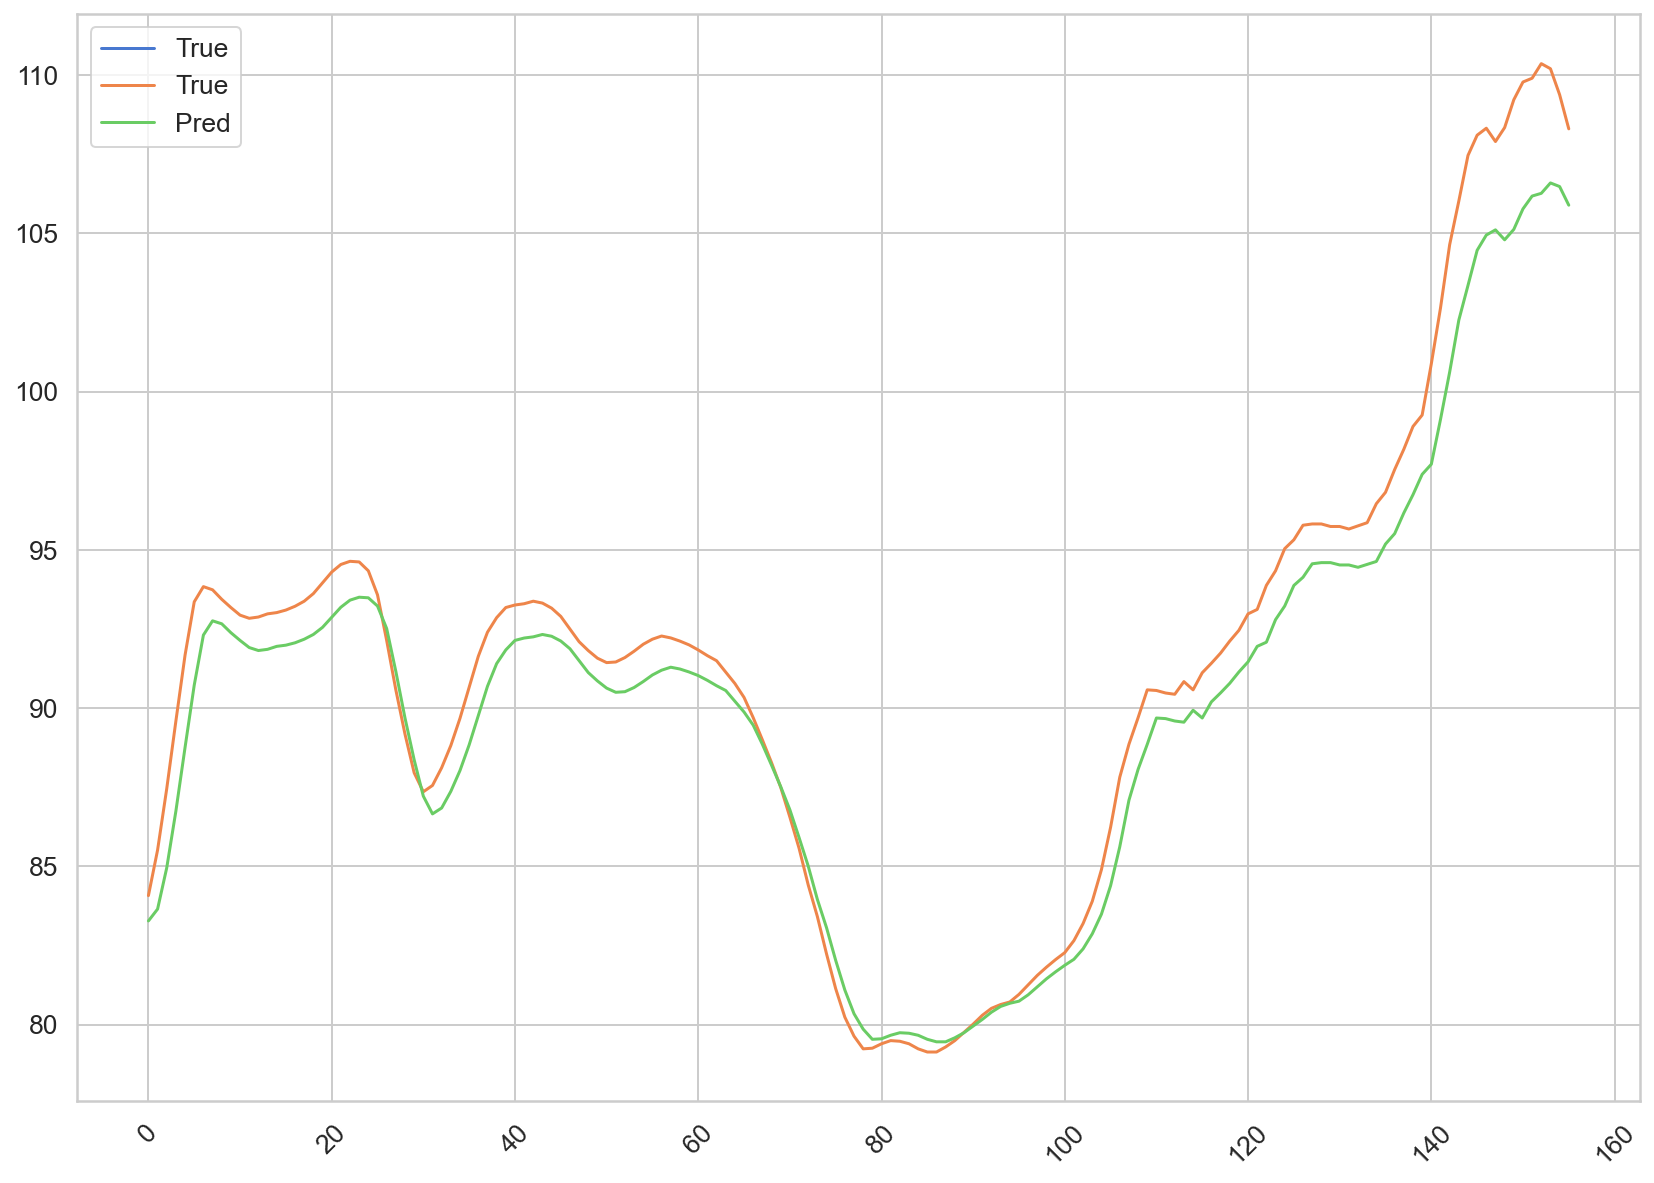

In [17]:
plt.plot(data.index[:-len(y_test)-2*seq_length+1], y[:0], label='True')
plt.plot(data.index[-len(y_test):]-seq_length*2+1, y[0:], label='True')
plt.plot(data.index[-len(preds):]-seq_length*2+1, preds, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In [168]:
#multi-step 예측

with torch.no_grad():
    test_seq = X_test[:1] # 첫번째 테스트 셋, 3차원
    preds = []
    for _ in range(len(X_test)):
        model.module.reset_hidden_state()
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.cpu().numpy().flatten()
        new_seq = np.append(new_seq, [pred]) # 시퀀스에 추가 
        new_seq = new_seq[1:] # 추가된 값을 포함하여 seq_length가 5개가 되도록 맞추기 
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [169]:
preds= sc.inverse_transform(np.array(preds).reshape(-1,1))
preds

array([[106.18551698],
       [105.78558325],
       [105.54447542],
       [105.42033116],
       [105.36261793],
       [105.33721136],
       [105.32631147],
       [105.32168826],
       [105.31973698],
       [105.31891515],
       [105.31856918],
       [105.31842368],
       [105.31836257],
       [105.31833683]])

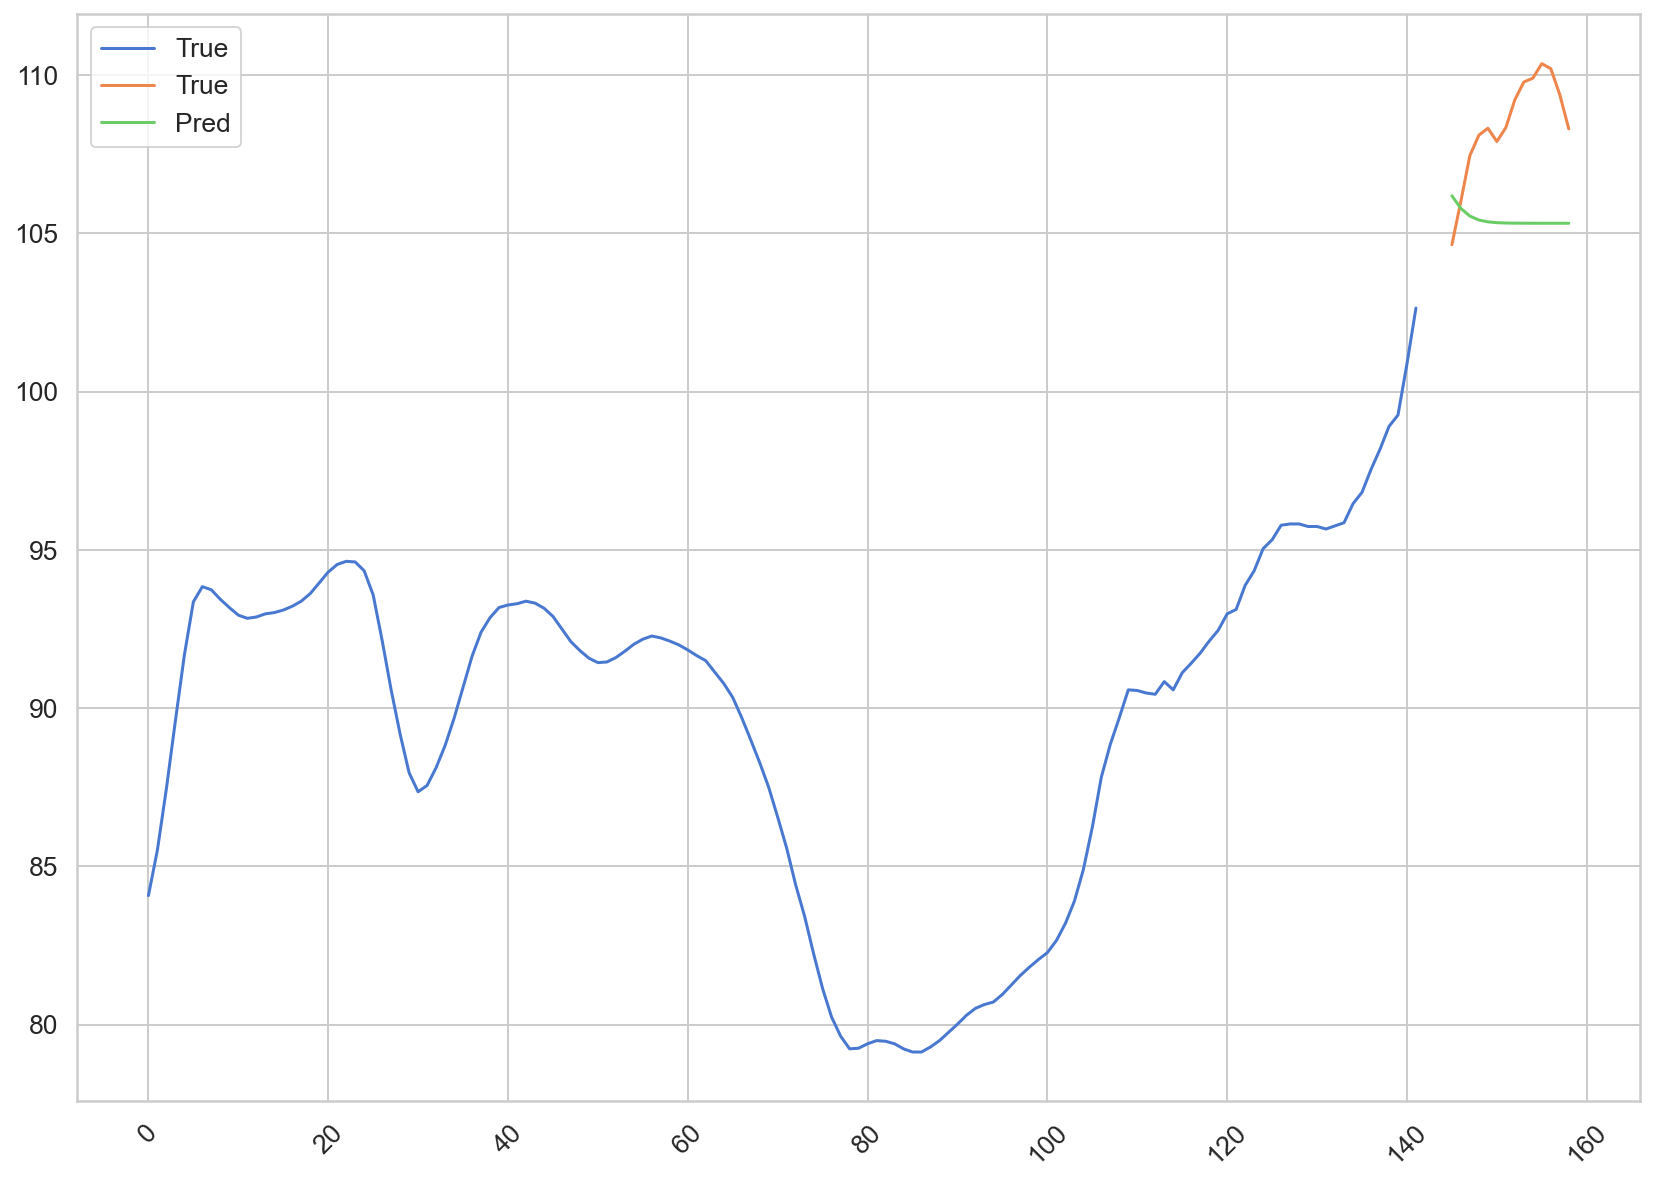

In [170]:
plt.plot(data.index[:-len(y_test)-2*seq_length+1], y[:-len(y_test)], label='True')
plt.plot(data.index[-len(y_test):]-seq_length-1, y[-len(y_test):], label='True')
plt.plot(data.index[-len(preds):]-seq_length-1, preds, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In [1]:
#######################################################################################################

#가중치 부여

#######################################################################################################

In [19]:
len(preds)

156

In [20]:
preds13=preds[76:89]
preds14=preds[89:102]
preds15=preds[102:115]
preds16=preds[115:128]
preds17=preds[128:141]
preds18=preds[141:154]
preds19=preds[154:]

In [21]:
def deriv(array, weight, alpha):
    ret= []
    for i in range(len(array)-1):
        diff=array[i+1]-array[i]
        if weight>0:
            ret.append(array[i]+diff*weight*alpha)
        else:
            ret.append(array[i]-diff*weight*alpha)
            
    ret.append(array[i+1])
    return ret

In [22]:
weight13=-8
weight14=2
weight15=5
weight16=4
weight17=-6
weight18=-2
weight19=10

In [57]:
alpha=0.5
year13= deriv(preds13,weight13,alpha)
year14= deriv(preds14,weight14,alpha)
year15= deriv(preds15,weight15,alpha)
year16= deriv(preds16,weight16,alpha)
year17= deriv(preds17,weight17,alpha)
year18= deriv(preds18,weight18,alpha)
year19= deriv(preds19,weight19,alpha)


In [58]:
wholeyear= preds[:76].flatten().tolist()+year13+year14+year15+year16+year17+year18+year19

In [59]:
len(wholeyear)

156

c:\users\aaa\anaconda3\envs\pytorch\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


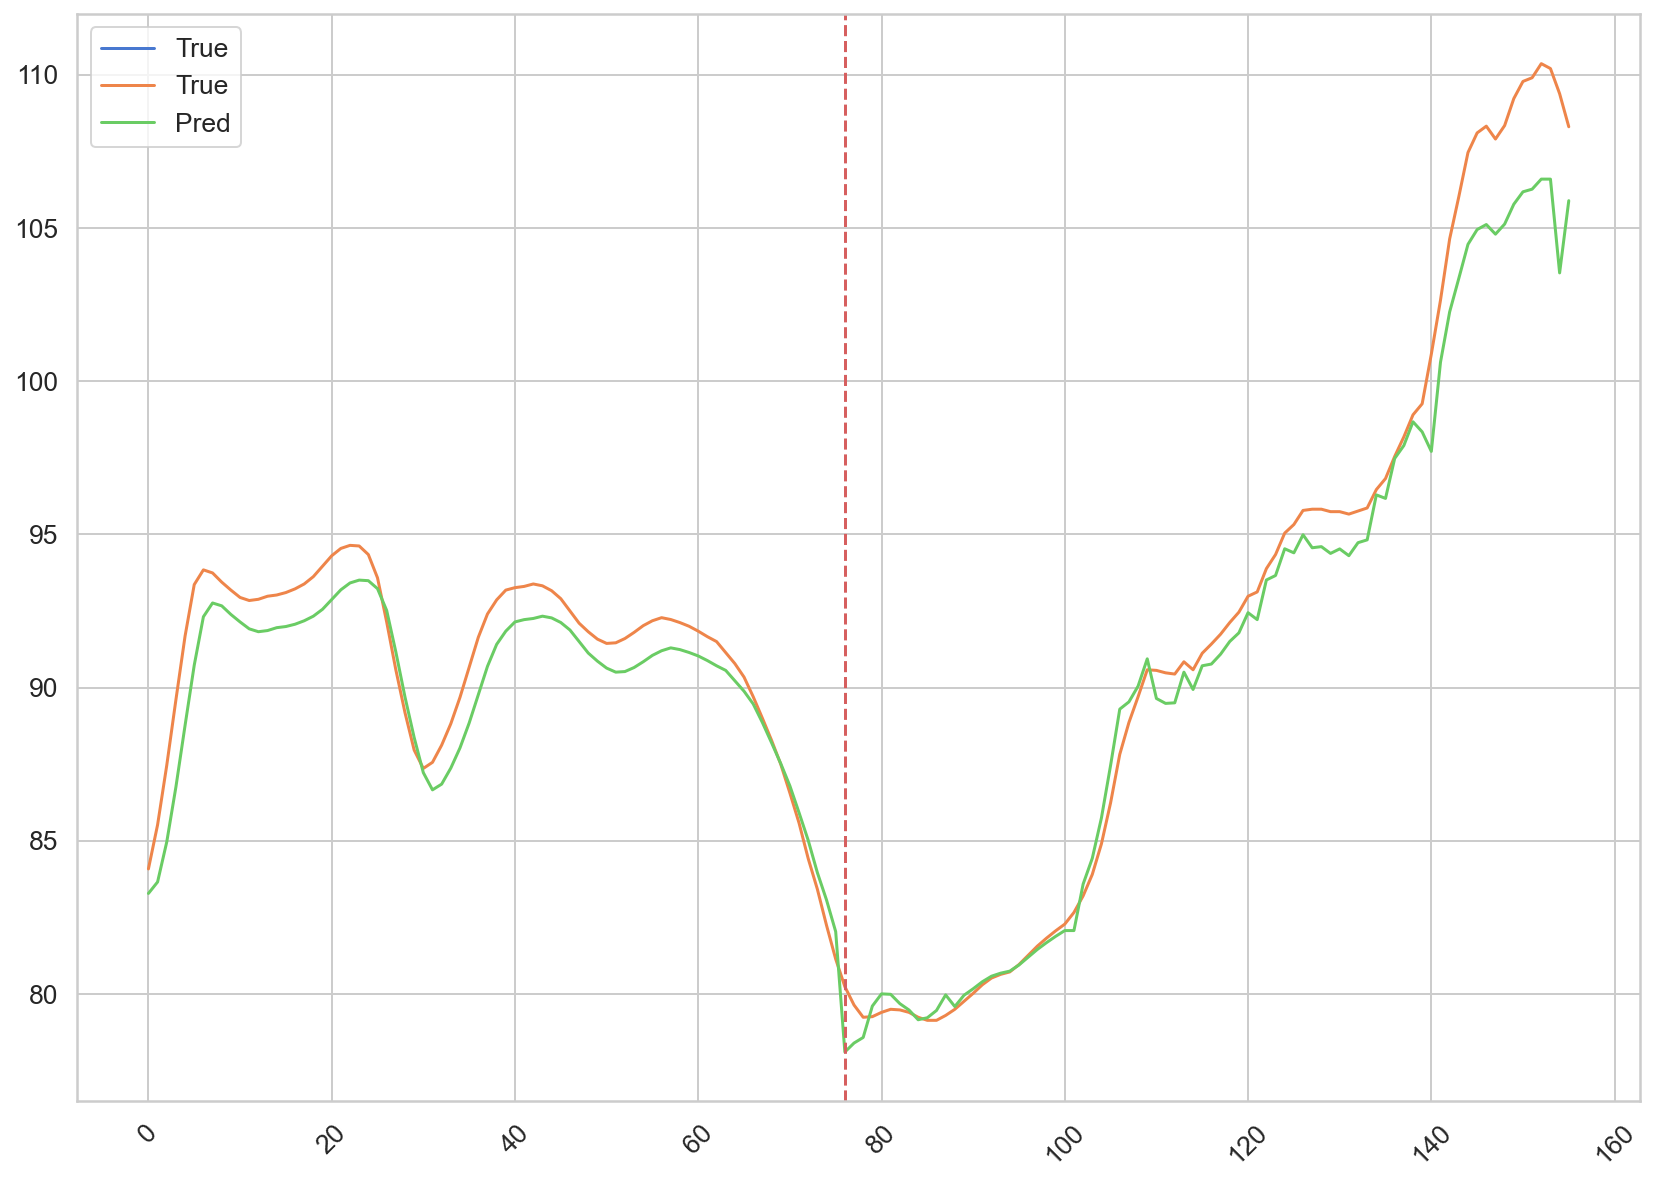

In [60]:
plt.plot(data.index[:-len(y_test)-2*seq_length+1], y[:0], label='True')
plt.plot(data.index[-len(y_test):]-seq_length*2+1, y[0:], label='True')
plt.plot(data.index[-len(preds):]-seq_length*2+1, wholeyear, label='Pred')
plt.axvline(x=76, c='r', linestyle='--') 
plt.xticks(rotation=45)
plt.legend()

In [61]:
#######################################################################################################

#가중치 부여2

#######################################################################################################

In [107]:
alpha=0.02

ret=[preds[75].item()]
for i in range(len(preds[76:156])):
    diff= preds[76+i]-preds[75+i]
    
    if i<=13:
        weight= weight13
    elif i<=26:
        weight= weight14
    elif i<=39:
        weight= weight15
    elif i<=52:
        weight= weight16
    elif i<=65:
        weight= weight17
    elif i<=78:
        weight= weight18
    else:
        weight= weight19
    
    
    if weight>0:
        ret.append((ret[i]+diff+diff*weight*alpha).item())
    else:
        ret.append((ret[i]+diff-diff*weight*alpha).item())
    

In [108]:
ret

[82.03476312100887,
 80.94667302207945,
 80.07940278561114,
 79.51373401943442,
 79.14250169894694,
 79.16094850474595,
 79.29041774286031,
 79.38325725750921,
 79.36466474660634,
 79.29041774286031,
 79.14250169894694,
 79.05044953150748,
 79.05044953150748,
 79.19787881244419,
 79.3832572575092,
 79.60091995275017,
 79.82035537481306,
 80.05860908555982,
 80.2471877394676,
 80.35055067963599,
 80.41965315809249,
 80.6278808244705,
 80.89006344437597,
 81.1542965054035,
 81.38490581555364,
 81.59906224679943,
 81.79643002610204,
 82.13963361587521,
 82.66053243263957,
 83.34397897007463,
 84.33470128908155,
 85.68453616687056,
 87.30088912644383,
 88.37478077473638,
 89.24565766843554,
 90.1596974196076,
 90.1389168572068,
 90.0557905137181,
 90.01423143585916,
 90.42986315330262,
 90.15969741960758,
 90.71058128606076,
 91.01652783886189,
 91.34272036706206,
 91.7297714049935,
 92.07571953555342,
 92.60397188235518,
 92.7459891398072,
 93.51513925186391,
 93.97896984549757,
 94.68187

In [109]:
wholeyear=  preds[:75].flatten().tolist()+ret
len(wholeyear)

156

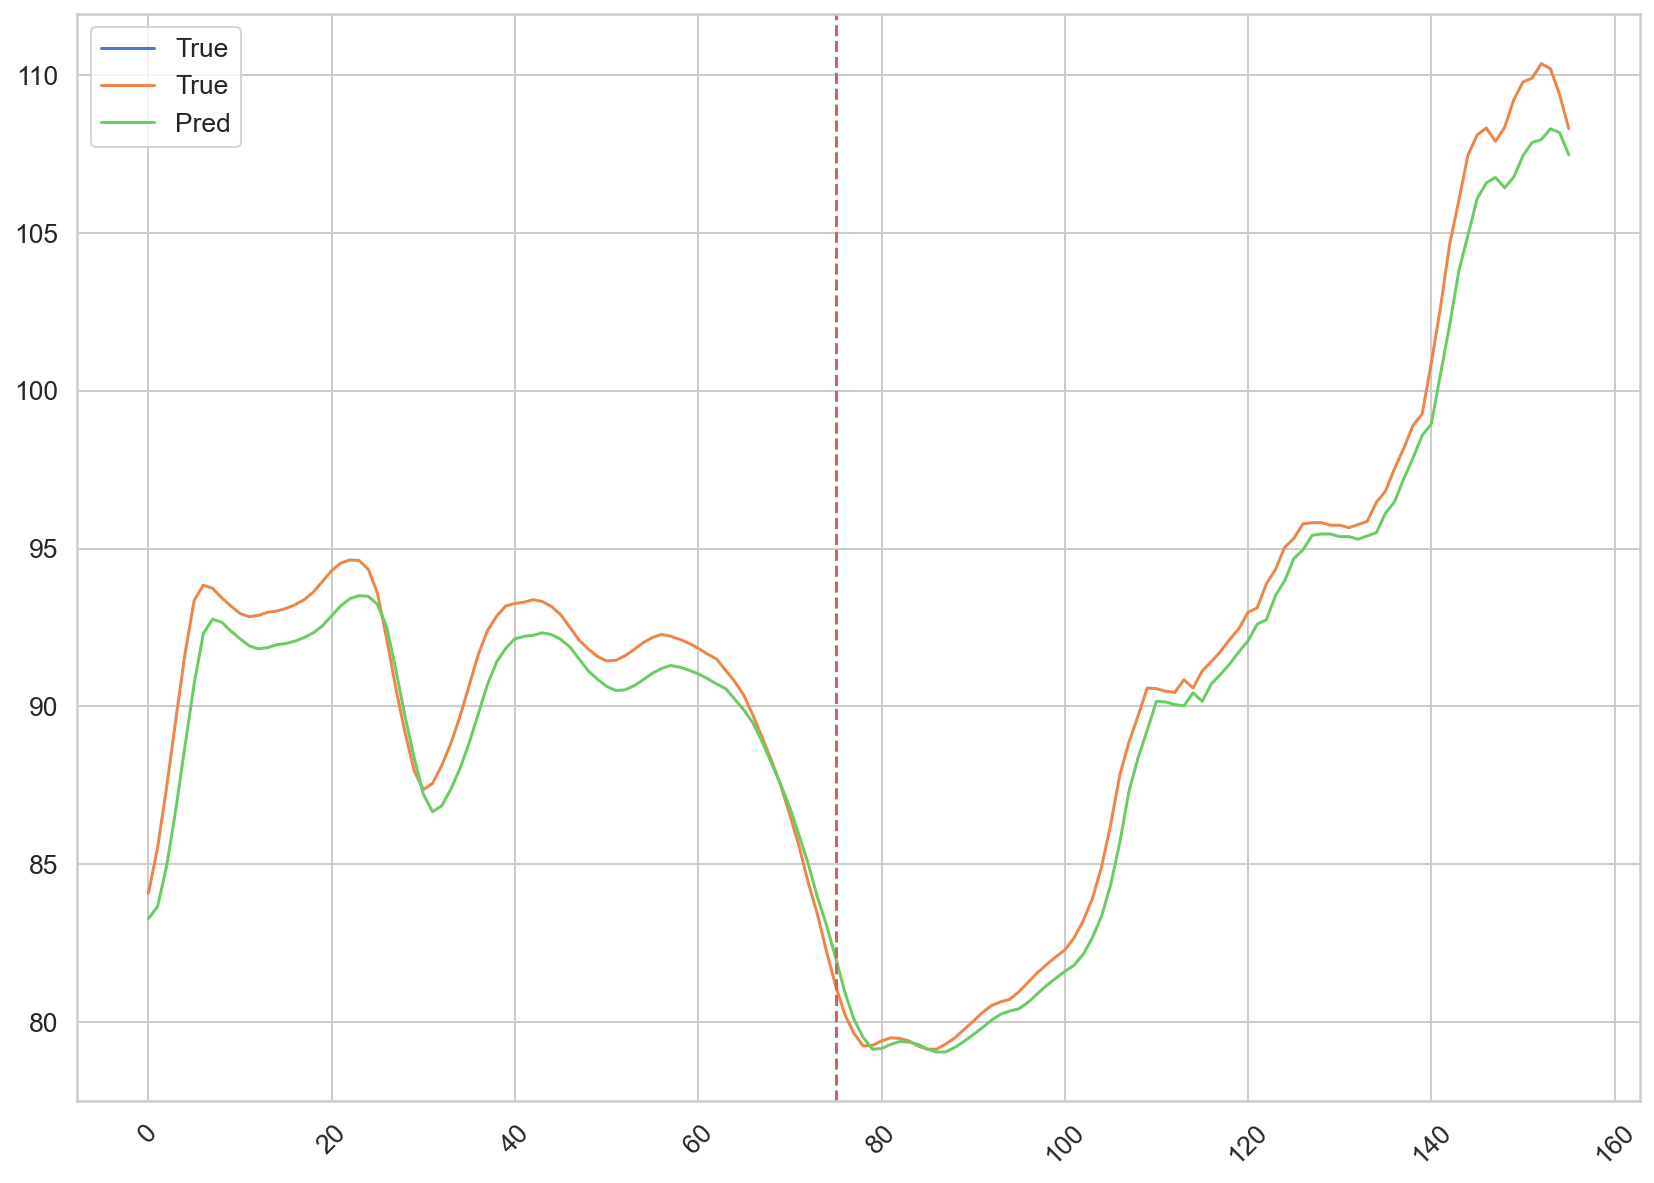

In [110]:
plt.plot(data.index[:-len(y_test)-2*seq_length+1], y[:0], label='True')
plt.plot(data.index[-len(y_test):]-seq_length*2+1, y[0:], label='True')
plt.plot(data.index[-len(preds):]-seq_length*2+1, wholeyear, label='Pred')
plt.axvline(x=75, c='r', linestyle='--') 
plt.xticks(rotation=45)
plt.legend()

In [114]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

MAE(y[0:],np.array(wholeyear).reshape(-1,1))

0.964832346049578

In [113]:
np.array(wholeyear).reshape(-1,1)

array([[ 83.28027845],
       [ 83.65524114],
       [ 84.96004709],
       [ 86.75489299],
       [ 88.76501492],
       [ 90.72908809],
       [ 92.31024154],
       [ 92.7598004 ],
       [ 92.66624395],
       [ 92.38525082],
       [ 92.1413576 ],
       [ 91.91594083],
       [ 91.82194522],
       [ 91.85954942],
       [ 91.95352828],
       [ 91.99111014],
       [ 92.06624597],
       [ 92.17889853],
       [ 92.32899898],
       [ 92.55390402],
       [ 92.87198403],
       [ 93.18938296],
       [ 93.41297796],
       [ 93.50602825],
       [ 93.48742527],
       [ 93.22667454],
       [ 92.51644124],
       [ 91.16293387],
       [ 89.69031118],
       [ 88.36901152],
       [ 87.22247704],
       [ 86.66157752],
       [ 86.8482773 ],
       [ 87.37242955],
       [ 88.0300192 ],
       [ 88.84049314],
       [ 89.76588245],
       [ 90.69133688],
       [ 91.40790453],
       [ 91.84074732],
       [ 92.1413576 ],
       [ 92.21643574],
       [ 92.2539655 ],
       [ 92